In [2]:
import pandas as pd
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn import set_config
set_config(transform_output="pandas")


In [11]:
class Clustering_songs:
    def __init__(self, df):
        self.df = df

    def scaling_transformation(self, method):
        """
            Description:
            Scales Dataframe to different weights, only ints or floats in df are allowed
            Parameters:
            df: dataframe| only ints or floats
            type: str | indicating which scaler to use
                        'minmax'
                        'std'
                        'robust'
                        'quantile'
                        'power'
            Returns:
                df with scaled values

        """
        if method == 'minmax':
            scaler = MinMaxScaler().set_output(transform="pandas")
        elif method == 'std':
            scaler = StandardScaler().set_output(transform="pandas")
        elif method == 'robust':
            scaler = RobustScaler().set_output(transform="pandas")
        elif method == 'quantile':
            scaler = QuantileTransformer(n_quantiles = self.df.shape[0]).set_output(transform="pandas")
        elif method == 'power':
            scaler = PowerTransformer().set_output(transform="pandas")
            
        # Use the transformer to transform/scale the data
        df_scaled = scaler.fit_transform(self.df)

        return df_scaled
    
    def compare_original_tranformed_df(self, scaled_transformed_df, x, feature, random_seed):
        """
        parameters:
            original_df: dataframe without any tranformation/scaling applied
            transformed_df: tranformed/scaled dataframe
            x: number of samples for the heatmap and the histogram
            feature: feature you specifically want to analyze via histogram and comparison tables
            random_seed: random state for which rows will randomly picked
        return: 
            nothing
        """
        # comparison of individual features
        #comparison_df = pd.DataFrame({'original': original_df[feature], 'quantiletransformed': quantile_df[feature]})

        random_indices = self.df.sample(n = x, random_state = random_seed).index
        
        original_df_excerpt = self.df.loc[random_indices]
        scaled_transformed_df_excerpt = scaled_transformed_df.loc[random_indices]

        # create heatmap without including any scalars or transformers
        original_df_excerpt_distances = pd.DataFrame(pairwise_distances(original_df_excerpt),
                                                    index = original_df_excerpt.index,
                                                    columns = original_df_excerpt.index)
        
        scaled_transformed_df_excerpt_distances = pd.DataFrame(pairwise_distances(scaled_transformed_df_excerpt),
                                                    index = scaled_transformed_df_excerpt.index,
                                                    columns = scaled_transformed_df_excerpt.index)

        # Plotting
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

        sns.heatmap(original_df_excerpt_distances, ax = ax1)
        ax1.set_title('Original data')

        sns.heatmap(scaled_transformed_df_excerpt_distances, ax = ax2)
        ax2.set_title('Scaled/transformed data')


        sns.histplot(data = original_df_excerpt[feature], bins = x, kde = True, ax = ax3)
        ax3.set_title(f'Original {feature} histogram')
        
        sns.histplot(data = scaled_transformed_df_excerpt[feature], bins = x, kde = True, ax = ax4)
        ax4.set_title(f'Scaled/transformed {feature} histogram')

        plt.tight_layout()

    def pca(self, scaled_transformed_df):

        pca = PCA(n_components = 0.95)
        pca.fit(scaled_transformed_df)
        pca_df = pca.transform(scaled_transformed_df)

        return pca_df


    def find_k(self, scaled_transformed_df, min_k, max_k, seed):
        """
        parameters:
            scaled_transformed_df: dataframe that has been transformed or scaled with function compare_original_and_quantile_feature(original_df, x, feature, random_seed)
            min_k: minimum number of clusters
            max_k: maximum number of clusters
            seed: random state 
        """

        intertia_list = []
        sil_scores = []

        for i in range(min_k, max_k + 1):
            kMeans = KMeans(n_clusters = i,
                            n_init = "auto",
                            random_state = seed)
            kMeans.fit(scaled_transformed_df)
            intertia_list.append(kMeans.inertia_)
            labels = kMeans.labels_
            score = silhouette_score(scaled_transformed_df, labels)
            sil_scores.append(score)


        sns.set_theme(style='darkgrid')

        (
        sns.relplot(y = intertia_list,
                    x = range(min_k, max_k + 1),
                    kind = 'line',
                    marker = 'o',
                    height = 8,
                    aspect = 2)
        .set(title = f"Inertia score from {min_k} to {max_k} clusters")
        .set_axis_labels("Number of clusters", "Inertia score")
        );

        (
        sns.relplot(y = sil_scores,
                    x = range(min_k, max_k + 1),
                    kind = 'line',
                    marker = 'o',
                    height = 8,
                    aspect = 2)
        #.set(title = f"Silhouette score from {min_k} to {max_k} + 1 clusters")
        .set_axis_labels("Number of clusters", "Silhouette score", fontsize=20)
        );


    def clustering_n_dim(self, df, k, random_seed):
        full_kmeans = KMeans(n_clusters = k,
                            random_state = random_seed)
        full_kmeans.fit(df)
        table = full_kmeans.labels_
        df["cluster"] = table
        return df
        #df_sorted = df.sort_values(by="cluster")
        #return df_sorted

In [4]:
spotify_df = pd.read_csv('3_spotify_5000_songs.csv', index_col = 'Unnamed: 0')
spotify_df.columns = spotify_df.columns.str.strip()
to_drop = ['name', 'artist', 'mode', 'duration_ms', 'id', 'time_signature', 'html', 'time_signature', 'type']
spotify_df_reduced = spotify_df.drop(columns=to_drop).copy()

In [5]:
# create an instance of the class
clustering_instance = Clustering_songs(spotify_df_reduced)

In [6]:
# apply a scaling:
robust_transformed_df = clustering_instance.scaling_transformation('robust')

In [8]:
spotify_df_reduced

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.6580,0.25900,11,-13.141,0.0705,0.694,0.000059,0.9750,0.3060,110.376
1,0.7420,0.39900,2,-12.646,0.0346,0.217,0.000002,0.1070,0.6930,125.039
2,0.8510,0.73000,2,-11.048,0.3470,0.453,0.000063,0.1240,0.9050,93.698
3,0.7050,0.05020,4,-18.115,0.0471,0.879,0.000041,0.3860,0.5240,106.802
4,0.6510,0.11900,6,-19.807,0.0380,0.916,0.000343,0.1040,0.4020,120.941
...,...,...,...,...,...,...,...,...,...,...
5230,0.2020,0.06940,3,-23.390,0.0473,0.917,0.715000,0.0832,0.0655,87.906
5231,0.1880,0.10100,6,-21.873,0.0442,0.855,0.426000,0.0694,0.0355,83.134
5232,0.0596,0.00093,9,-42.959,0.0434,0.951,0.969000,0.0772,0.0344,71.573
5233,0.1330,0.02080,4,-29.443,0.0419,0.883,0.505000,0.1110,0.0591,67.109


In [7]:
robust_transformed_df

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.313984,-1.157005,1.000000,-0.955541,0.246438,1.063138,-0.002833,5.882353,-0.230769,-0.232633
1,0.535620,-0.818841,-0.500000,-0.874033,-0.355407,0.215967,-0.002921,-0.124567,0.573805,0.154816
2,0.823219,-0.019324,-0.500000,-0.610901,4.881811,0.635112,-0.002825,-0.006920,1.014553,-0.673325
3,0.437995,-1.661353,-0.166667,-1.774576,-0.145851,1.391706,-0.002861,1.806228,0.222453,-0.327071
4,0.295515,-1.495169,0.166667,-2.053186,-0.298407,1.457419,-0.002390,-0.145329,-0.031185,0.046532
...,...,...,...,...,...,...,...,...,...,...
5230,-0.889182,-1.614976,-0.333333,-2.643175,-0.142498,1.459195,1.109053,-0.289273,-0.730769,-0.826371
5231,-0.926121,-1.538647,0.166667,-2.393381,-0.194468,1.349081,0.659597,-0.384775,-0.793139,-0.952464
5232,-1.264908,-1.780362,0.666667,-5.865470,-0.207879,1.519581,1.504077,-0.330796,-0.795426,-1.257947
5233,-1.071240,-1.732367,-0.166667,-3.639881,-0.233026,1.398810,0.782458,-0.096886,-0.744075,-1.375902


In [9]:
robust_transformed_pca_df = clustering_instance.pca(robust_transformed_df)

In [10]:
robust_transformed_pca_df

,pca0,pca1,pca2,pca3,pca4,pca5,pca6
0,0.047937,0.094044,5.429036,1.453643,0.462327,0.921797,-0.439820
1,-0.838632,-0.691908,-0.533856,0.641386,0.510957,-0.497327,0.296778
2,2.158718,3.457972,-1.044947,1.998786,0.176691,-0.595117,0.549465
3,-1.723684,0.187734,1.567998,1.490205,0.607838,-0.163217,-0.194227
4,-2.303099,0.247676,-0.240701,0.874438,0.781540,0.216339,-0.259728
...,...,...,...,...,...,...,...
5230,-3.189608,1.259928,-0.020505,-0.101644,-0.317922,-0.337935,-0.168972
5231,-2.965046,1.047881,-0.158131,0.000145,-0.492589,0.169250,-0.447180
5232,-5.433956,2.687545,0.445643,-0.146495,-0.334520,0.650656,1.188392
5233,-3.873029,1.600297,0.309003,0.213937,-0.640461,-0.177202,0.043052


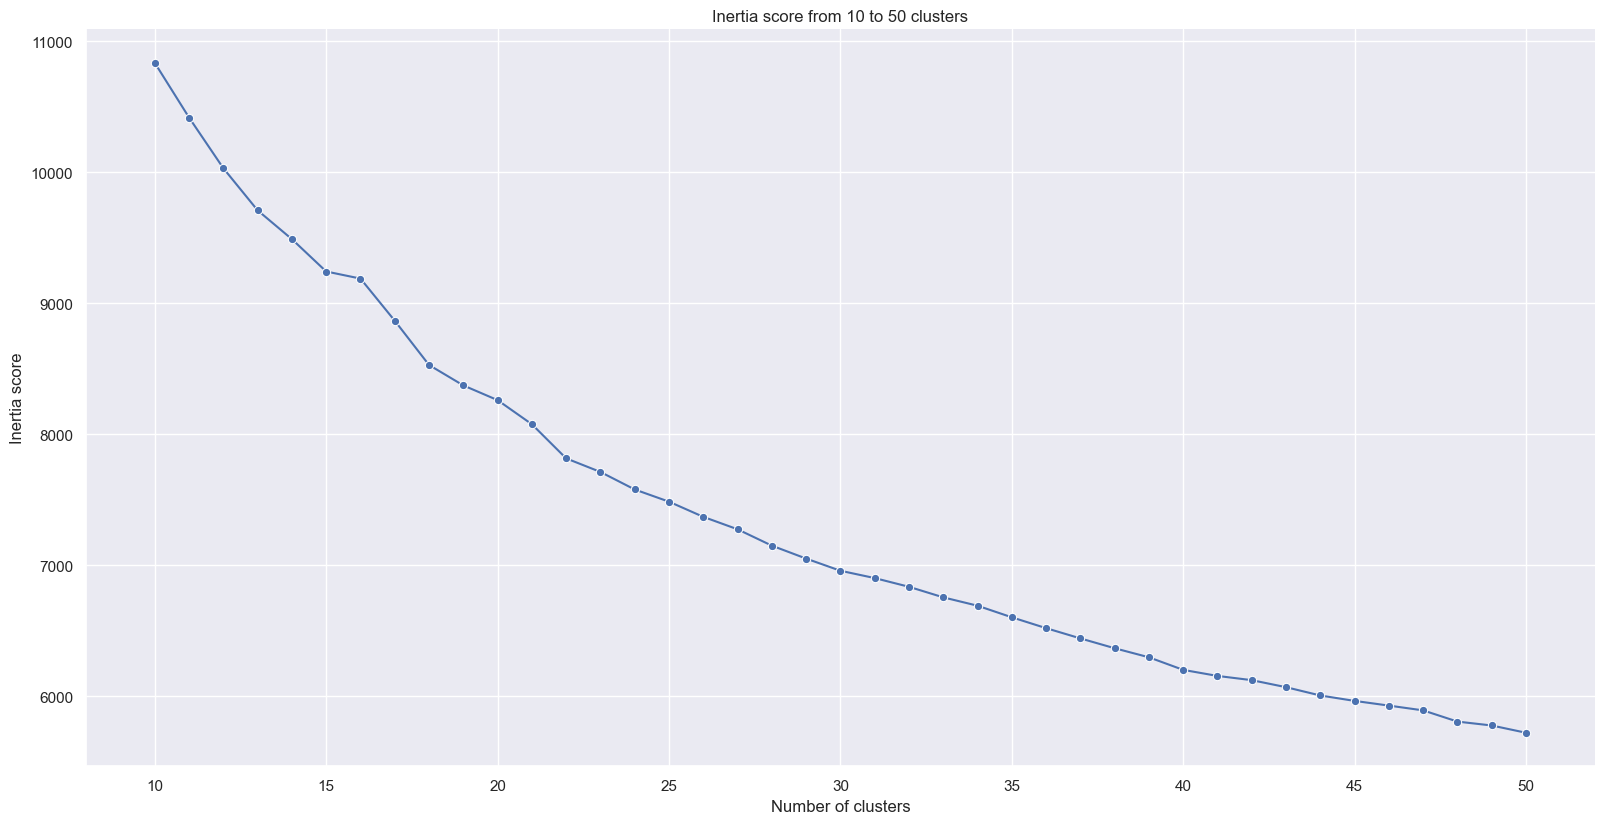

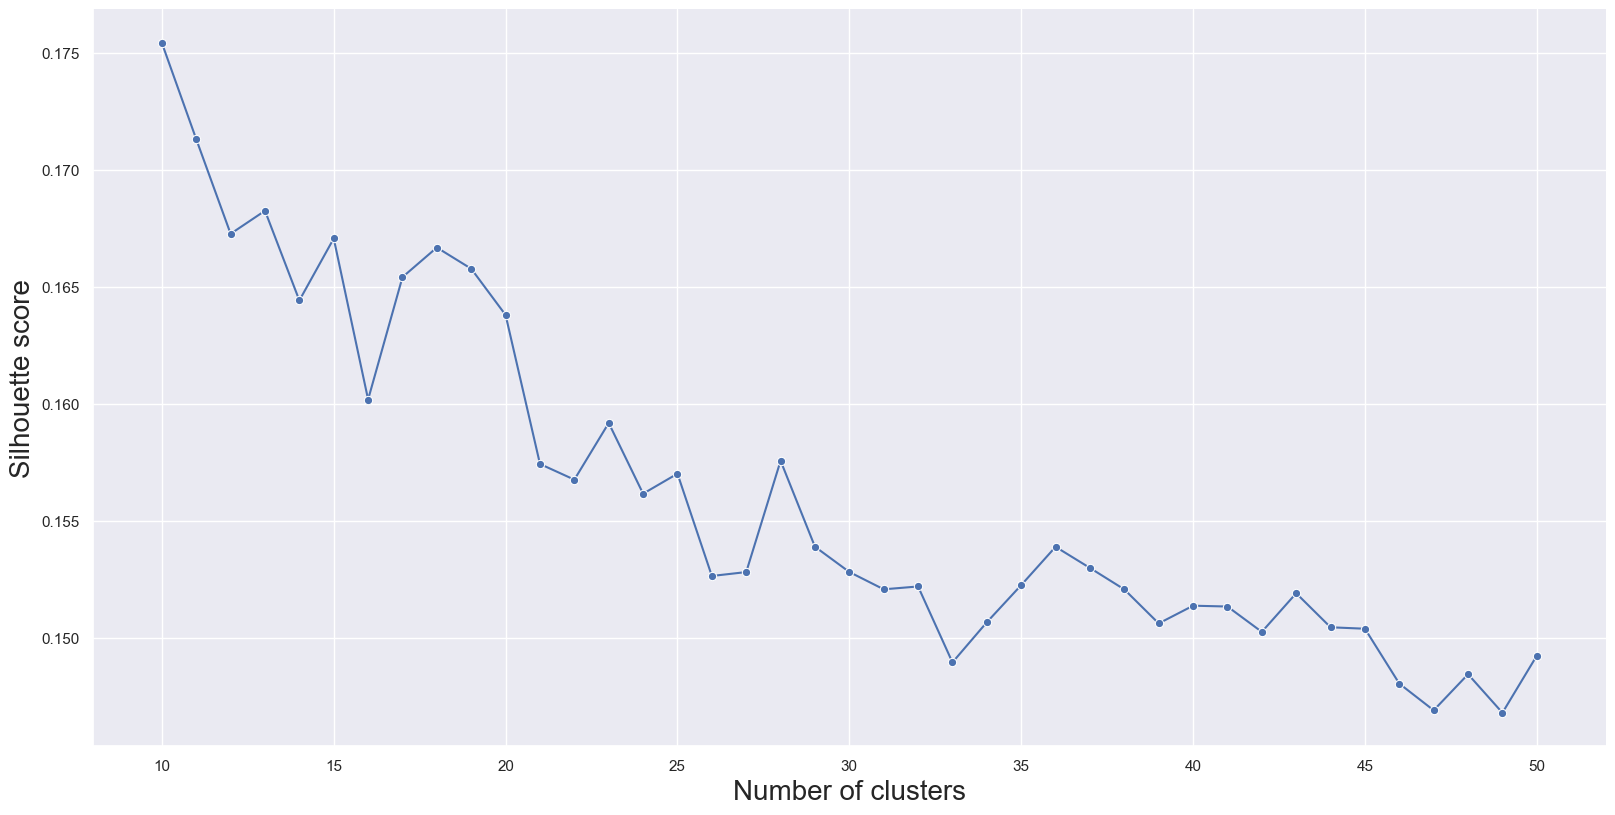

In [66]:
clustering_instance.find_k(robust_transformed_pca_df, 10, 50, 123)

In [27]:
clustered_df = clustering_instance.clustering_n_dim(robust_transformed_pca_df, 23, 123)
clustered_df

/Users/lalalulu/Library/Python/3.8/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,pca0,pca1,pca2,pca3,pca4,pca5,pca6,cluster
0,0.047937,0.094044,5.429036,1.453643,0.462327,0.921797,-0.439820,19
1,-0.838632,-0.691908,-0.533856,0.641386,0.510957,-0.497327,0.296778,21
2,2.158718,3.457972,-1.044947,1.998786,0.176691,-0.595117,0.549465,15
3,-1.723684,0.187734,1.567998,1.490205,0.607838,-0.163217,-0.194227,14
4,-2.303099,0.247676,-0.240701,0.874438,0.781540,0.216339,-0.259728,1
...,...,...,...,...,...,...,...,...
5230,-3.189608,1.259928,-0.020505,-0.101644,-0.317922,-0.337935,-0.168972,8
5231,-2.965046,1.047881,-0.158131,0.000145,-0.492589,0.169250,-0.447180,8
5232,-5.433956,2.687545,0.445643,-0.146495,-0.334520,0.650656,1.188392,5
5233,-3.873029,1.600297,0.309003,0.213937,-0.640461,-0.177202,0.043052,5


In [40]:
songs_df_assessing =  pd.concat([spotify_df_reduced, clustered_df['cluster']], axis=1)
songs_df_grouped = songs_df_assessing.groupby('cluster').mean()
#songs_df_grouped['energy'].sum()

14.579061929092225

In [ ]:
songs_df_assessing

In [35]:
spotify_df_clustered =  pd.concat([spotify_df, clustered_df['cluster']], axis=1)
spotify_df_clustered_sorted = spotify_df_clustered.sort_values(by = 'cluster')

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html,cluster
4981,Sola ...,Anuel AA,0.639,0.869,11,-4.024,1,0.1470,0.270000,0.00000,0.0802,0.7670,169.801,,307910,4,5q2JbCNi4FcnglgPfxcV65,https://open.spotify.com/track/5q2JbCNi4Fcnglg...,0
4883,Liebe ...,Sido,0.462,0.812,6,-5.988,1,0.3110,0.057300,0.00000,0.1860,0.6320,172.461,,195416,4,4zvYEncfgiI59ng3gFMvKE,https://open.spotify.com/track/4zvYEncfgiI59ng...,0
3146,54-46 Was My Number ...,The Maytals,0.703,0.355,0,-7.761,1,0.1600,0.204000,0.00001,0.0642,0.6380,159.104,,190760,4,36aH0Y3Zy5jCRpVLvbXBL7,https://open.spotify.com/track/36aH0Y3Zy5jCRpV...,0
4096,The Battle of Armageddon ...,Opprobrium,0.105,0.979,7,-4.482,1,0.2190,0.000002,0.85000,0.2680,0.1260,173.012,,372649,4,2qd3MUseNFDKHAeiJBxDTe,https://open.spotify.com/track/2qd3MUseNFDKHAe...,0
4901,Astronaut ...,Sido,0.665,0.662,8,-6.874,0,0.2710,0.171000,0.00000,0.0831,0.3810,149.976,,238213,4,0pQr5WsobmdZHnuObT0sc2,https://open.spotify.com/track/0pQr5WsobmdZHnu...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3815,Abigor ...,Cryptopsy,0.232,0.961,9,-14.036,1,0.0503,0.000263,0.92900,0.3630,0.1610,102.172,,231427,4,4kfpbmx9zcQeZLPKNLCO2A,https://open.spotify.com/track/4kfpbmx9zcQeZLP...,22
3452,Zombie Ritual ...,Death,0.221,0.941,2,-6.662,1,0.0788,0.000001,0.11700,0.3510,0.1890,113.236,,272688,4,6SjRA2uuTOwXxErnp3SfDZ,https://open.spotify.com/track/6SjRA2uuTOwXxEr...,22
4241,Resistance ...,Morgoth,0.271,0.960,8,-7.358,1,0.0991,0.000034,0.23400,0.4340,0.0437,110.931,,289067,4,2LZcGCaoHpg23t6a2sEx5k,https://open.spotify.com/track/2LZcGCaoHpg23t6...,22
3998,Brutal Warfare ...,Mortification,0.288,0.953,7,-8.914,1,0.0533,0.000012,0.65700,0.3190,0.5290,104.219,,238333,4,6Ly8YRAmHhn94hjtCPX9XX,https://open.spotify.com/track/6Ly8YRAmHhn94hj...,22


## Final table

In [42]:
#final_df = pd.read_csv('final_table.csv')
final_df = pd.read_csv('final_table.csv')


In [43]:
final_df

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html,cluster
0,Gelid Remains ...,Demolition Hammer,0.290,0.848,11,-12.568,1,0.0603,0.000004,0.011500,0.0807,0.4810,86.888,,323467,4,7q3q0x8ia0fnwnkJO4Sz6Z,https://open.spotify.com/track/7q3q0x8ia0fnwnk...,0
1,Siege Of Power ...,Napalm Death,0.326,0.879,3,-14.048,1,0.0671,0.000006,0.732000,0.2230,0.3040,136.633,,213067,4,10PTfUSviOQVm4sbniYuHd,https://open.spotify.com/track/10PTfUSviOQVm4s...,0
2,The Forteress ...,Agressor,0.258,0.913,5,-10.903,0,0.0763,0.000015,0.871000,0.1050,0.4540,105.038,,237827,4,1otviBOlT3Ball9Qm0TWDp,https://open.spotify.com/track/1otviBOlT3Ball9...,0
3,Epilpetic Aura ...,Agressor,0.317,0.881,0,-9.656,1,0.0586,0.000005,0.842000,0.0667,0.5420,100.899,,187933,4,2XkSIlOgp84pme4GipCKWa,https://open.spotify.com/track/2XkSIlOgp84pme4...,0
4,Lost in Grave ...,Fleshcrawl,0.251,0.825,6,-9.754,1,0.0426,0.000326,0.693000,0.1350,0.0656,87.928,,425427,4,2EbbyTwFHzQ4epRQcGUIPd,https://open.spotify.com/track/2EbbyTwFHzQ4epR...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,Dr. Who! - UK Radio Edit ...,Tujamo,0.821,0.843,7,-4.733,1,0.0693,0.016700,0.000189,0.1110,0.8110,124.912,,159120,4,7pMt4h16E2jyQ5ZMyry41C,https://open.spotify.com/track/7pMt4h16E2jyQ5Z...,22
5231,Tanz der Moleküle - Single Version ...,Mia.,0.751,0.635,11,-5.953,0,0.0339,0.260000,0.036100,0.0789,0.8880,126.049,,238480,4,1mp5PVgUpnHflPu9URvsCk,https://open.spotify.com/track/1mp5PVgUpnHflPu...,22
5232,Nothing Compares 2 U ...,Sinéad O'Connor,0.511,0.574,5,-7.016,1,0.0273,0.042500,0.000023,0.1050,0.1610,119.917,,280040,4,3nvuPQTw2zuFAVuLsC9IYQ,https://open.spotify.com/track/3nvuPQTw2zuFAVu...,22
5233,Kommt meine Liebe nicht bei dir An - Single Ve...,Lukas Hilbert,0.544,0.633,11,-7.236,1,0.0333,0.610000,0.000000,0.1150,0.5800,139.994,,217385,4,3fNxkM4VP435ekWYGMduTD,https://open.spotify.com/track/3fNxkM4VP435ekW...,22
